In [30]:
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
from langgraph.types import Command,Literal
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,ToolMessage
from langgraph.graph import MessagesState,START,END,StateGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_experimental.tools import PythonREPLTool
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing import Annotated
from pprint import pprint
from pydantic import BaseModel,Field

In [32]:
llm= ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=0.1)

In [33]:
@tool
def add(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:
    """Adds two numbers together."""
    return a + b

@tool 
def subtract(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:
    """Subtracts the second number from the first."""
    return a - b

@tool
def multiply(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:   
    """Multiplies two numbers together."""
    return a * b

In [ ]:
add_agent = create_react_agent(model=llm,tools=[add],prompt="You are a helpful calculator. You can add numbers together.")
subtract_agent = create_react_agent(model=llm,tools=[subtract],prompt="You are a helpful calculator. You can subtract two numbers.")
multiply_agent = create_react_agent(model=llm,tools=[multiply],prompt="You are a helpful calculator. You can multiply numbers together.")

In [56]:
@tool
def add_agent_tool(prompt: str):
    """Adds two numbers together."""
    response = add_agent.invoke({'messages': prompt})
    return HumanMessage(content=response['messages'][-1].content)


@tool
def subtract_agent_tool(prompt: str):
    """Subtracts the second number from the first."""
    response = subtract_agent.invoke({'messages': prompt})
    return HumanMessage(content=response['messages'][-1].content)

@tool
def multiply_agent_tool(prompt: str):
    """Multiplies two numbers together."""
    response = multiply_agent.invoke({'messages': prompt})
    return HumanMessage(content=response['messages'][-1].content)

In [57]:
supervisor_agent = create_react_agent(model=llm,tools=[add_agent_tool,subtract_agent_tool,multiply_agent_tool],prompt="You are a supervisor agent. You are assigned with add,multiply,subtract agents as tools,You need to send prompts or commmands as inputs to them inorder to make them work seamlessly")

In [58]:
response = supervisor_agent.invoke({'messages':'add 2 and 3 and multiply the result by 4 and subtract 5 from the result'})

In [59]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

add 2 and 3 and multiply the result by 4 and subtract 5 from the result
================================== Ai Message ==================================
Tool Calls:
  add_agent_tool (80db0bfc-e869-4e70-b66d-c8d87b32241b)
 Call ID: 80db0bfc-e869-4e70-b66d-c8d87b32241b
  Args:
    prompt: add 2 and 3
================================= Tool Message =================================
Name: add_agent_tool

content='2 + 3 = 5' additional_kwargs={} response_metadata={}
================================== Ai Message ==================================
Tool Calls:
  multiply_agent_tool (c469fba5-d0f6-4379-b024-beed2719aa70)
 Call ID: c469fba5-d0f6-4379-b024-beed2719aa70
  Args:
    prompt: multiply 5 and 4
================================= Tool Message =================================
Name: multiply_agent_tool

content='The result of multiplying 5 and 4 is 20.' additional_kwargs={} response_metadata={}
==============

In [60]:
def calculator_agent(state:MessagesState):
    prompt = state['messages'][-1]
    response = supervisor_agent.invoke({'messages':prompt})
    state['messages'] = state['messages'] + response['messages']
    return state

In [61]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("Calculator", calculator_agent)


graph_builder.add_edge(START, "Calculator")
graph_builder.add_edge("Calculator", END)


In [62]:
graph = graph_builder.compile()

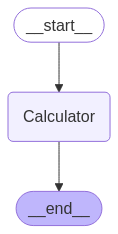

In [63]:
graph_builder.compile()

In [64]:
response = graph.invoke({'messages':'add 2 and 3 and multiply the result by 4'})
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

add 2 and 3 and multiply the result by 4
================================== Ai Message ==================================
Tool Calls:
  add_agent_tool (54f84797-6e8e-456c-9986-c4b3dbd7e0ad)
 Call ID: 54f84797-6e8e-456c-9986-c4b3dbd7e0ad
  Args:
    prompt: add 2 and 3
================================= Tool Message =================================
Name: add_agent_tool

content='2 + 3 = 5' additional_kwargs={} response_metadata={}
================================== Ai Message ==================================
Tool Calls:
  multiply_agent_tool (b9541ea7-5099-490c-8d55-041091eda905)
 Call ID: b9541ea7-5099-490c-8d55-041091eda905
  Args:
    prompt: multiply 5 and 4
================================= Tool Message =================================
Name: multiply_agent_tool

content='The result of multiplying 5 and 4 is 20.' additional_kwargs={} response_metadata={}
================================== Ai Message

In [65]:
response = graph.invoke({'messages':'add 2 and 3 and multiply the result by 10 and multiply it by -10'})
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

add 2 and 3 and multiply the result by 10 and multiply it by -10
================================== Ai Message ==================================
Tool Calls:
  add_agent_tool (82a4ed03-3e86-4a0f-93a3-212b876cb183)
 Call ID: 82a4ed03-3e86-4a0f-93a3-212b876cb183
  Args:
    prompt: add 2 and 3
================================= Tool Message =================================
Name: add_agent_tool

content='2 + 3 = 5' additional_kwargs={} response_metadata={}
================================== Ai Message ==================================
Tool Calls:
  multiply_agent_tool (13c1a417-54ee-4a12-9cad-99b931c81988)
 Call ID: 13c1a417-54ee-4a12-9cad-99b931c81988
  Args:
    prompt: multiply 5 and 10
================================= Tool Message =================================
Name: multiply_agent_tool

content='5 multiplied by 10 is 50.' additional_kwargs={} response_metadata={}
================================== 

In [66]:
response = graph.invoke({'messages':'add 2 and 3 and subtract the result by 10 and multiply it by -10'})
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

add 2 and 3 and subtract the result by 10 and multiply it by -10
================================== Ai Message ==================================
Tool Calls:
  add_agent_tool (f13d9b06-0411-4e11-bf64-6670005c187b)
 Call ID: f13d9b06-0411-4e11-bf64-6670005c187b
  Args:
    prompt: add 2 and 3
================================= Tool Message =================================
Name: add_agent_tool

content='2 + 3 = 5' additional_kwargs={} response_metadata={}
================================== Ai Message ==================================
Tool Calls:
  subtract_agent_tool (b8f75347-71b3-4deb-989a-247d3214d856)
 Call ID: b8f75347-71b3-4deb-989a-247d3214d856
  Args:
    prompt: subtract 10 from 5
================================= Tool Message =================================
Name: subtract_agent_tool

content='5 - 10 = -5' additional_kwargs={} response_metadata={}
================================== Ai Message ==